# 1. Dados do aluno

Jackes Tiago Ferreira da Fonseca - 190030291

# 2. Objetivo

Treinar um modelo tabular usando Regressão Linear

# 3. Motivação

Uma das preocupações no ambiente comercial é com o valor que uma mercadoria/produto deve possuir. Dentro do escopo automobilístico, sabemos que esse cenário é bem dinâmico e por muitas vezes determinada pelos próprios consumidores. Portanto, se faz necessário uma avaliação para prever o quanto um consumidor está disposto a pagar em um veículo com base em informações financeiras tal como: renda anual, patrimônio e dívidas que possui. Para este artigo, será utilizado o dataset [Car Purchasing Model](https://www.kaggle.com/datasets/dev0914sharma/car-purchasing-model/code) disponível na plataforma Kaggle a fim de realizar essa análise

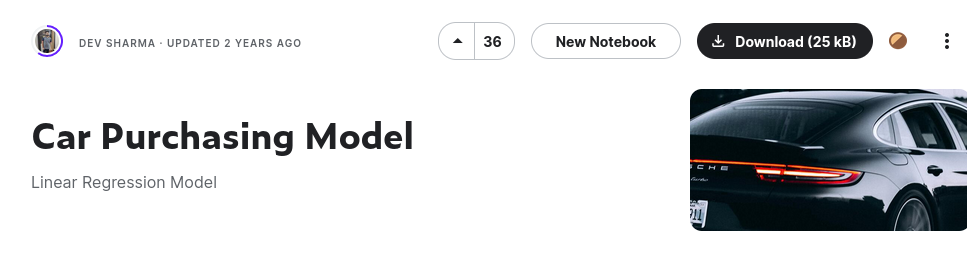

# 4. Modelagem

## 4.1 Importando dependências e setando configuração inicial

Nesse artigo serão utilizadas as bibliotecas:

- [Pathlib](https://docs.python.org/3/library/pathlib.html)
- [PyTorch](https://pytorch.org/docs/stable/index.html)
- [Numpy](https://numpy.org/doc/)
- [Pandas](https://pandas.pydata.org/docs/)
- [Scikit-learn](https://scikit-learn.org/stable/)
- [Seaborn](https://seaborn.pydata.org/)

In [ ]:
from pathlib import Path
import torch, numpy as np, pandas as pd
from sklearn import metrics
from sklearn.linear_model import LinearRegression #importing packages required for linearregression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score#to print the accurate value of predicted value
from torch import tensor
import seaborn as sns

Criamos uma variável que contém o caminho do arquivo que iremos utilizar como nosso dataset

In [ ]:
path = Path('/content/drive/MyDrive/Software Engeneering/8th - Semester/ML/cars')
path

PosixPath('/content/drive/MyDrive/Software Engeneering/8th - Semester/ML/cars')

## 4.2 Limpando os dados

Este é um dataset de dados tabulares - os dados estão na forma de uma tabela. Ele é fornecido como um arquivo de valores separados por vírgulas (CSV). Podemos abri-lo usando a biblioteca *pandas*, que criará um DataFrame

In [ ]:
df = pd.read_csv(path/'Car_Purchasing_Data.csv')
df

,Customer Name,Customer e-mail,Country,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,USA,0,42,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,USA,0,41,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,USA,1,43,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,USA,1,58,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,USA,1,57,59729.15130,5358.712177,560304.0671,55915.46248
...,...,...,...,...,...,...,...,...,...
495,Walter,ligula@Cumsociis.ca,USA,0,41,71942.40291,6995.902524,541670.1016,48901.44342
496,Vanna,Cum.sociis.natoque@Sedmolestie.edu,USA,1,38,56039.49793,12301.456790,360419.0988,31491.41457
497,Pearl,penatibus.et@massanonante.com,USA,1,54,68888.77805,10611.606860,764531.3203,64147.28888
498,Nell,Quisque.varius@arcuVivamussit.net,USA,1,59,49811.99062,14013.034510,337826.6382,45442.15353


Podemos observar que temos uma tabela com 9 colunas:

- Customer Name (Nome)
- Customer e-mail (e-mail)
- Country (país)
- Gender (gênero)
- Age (idade)
- Annual Salary (Salário anual)
- Credit Card Debt (Dívida do cartão de crédito)
- Net Worth (Patrimônio)
- Car purchase amount (Valor sugerido para compra do carro)

Para implementar nossa rede neural, precisamos multiplicar cada coluna por alguns coeficientes. Portanto, primeiramente verificamos se na tabela há alguma coluna que possue valores NaN, que é como o Pandas se refere aos valores ausentes. Não podemos multiplicar algo por um valor que falta!

In [ ]:
df.isna().sum()

Customer Name          0
Customer e-mail        0
Country                0
Gender                 0
Age                    0
Annual Salary          0
Credit Card Debt       0
Net Worth              0
Car Purchase Amount    0
dtype: int64

Como podemos observar, não há nenhuma coluna com valores ausentes. Já temos um bom começo. O pandas nos permite verificar um resumo rápido de todas as colunas numéricas no dataset

In [ ]:
df.describe(include=(np.number))

,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.506000,46.224000,62127.239608,9607.645049,431475.713625,44209.799218
std,0.500465,7.990339,11703.378228,3489.187973,173536.756340,10773.178744
min,0.000000,20.000000,20000.000000,100.000000,20000.000000,9000.000000
25%,0.000000,41.000000,54391.977195,7397.515792,299824.195900,37629.896040
50%,1.000000,46.000000,62915.497035,9655.035568,426750.120650,43997.783390
75%,1.000000,52.000000,70117.862005,11798.867487,557324.478725,51254.709517
max,1.000000,70.000000,100000.000000,20000.000000,1000000.000000,80000.000000


Uma situação muito comum em campos que contêm valores monetários e que pode causar problemas para nosso modelo, é a discrepância entre valores de uma coluna, pois uma vez que essa coluna é multiplicada por um coeficiente posteriormente, as poucas linhas com valores realmente grandes dominarão o resultado. Para isso, vamos verificar por meio de um histograma a distribuição dos nossos campos que contém valores monetários, já qe os demais campos possuem valores razoáveis.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


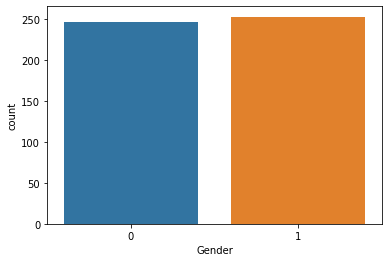

In [ ]:
sns.countplot(df['Gender']);

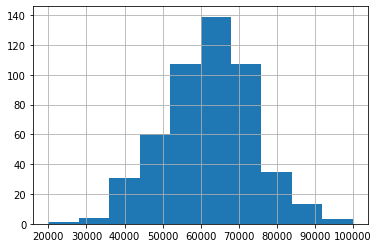

In [ ]:
df['Annual Salary'].hist();

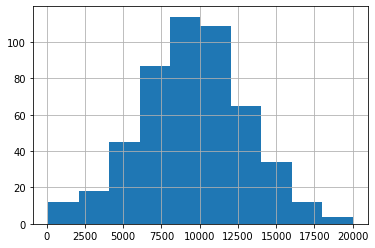

In [ ]:
df['Credit Card Debt'].hist();

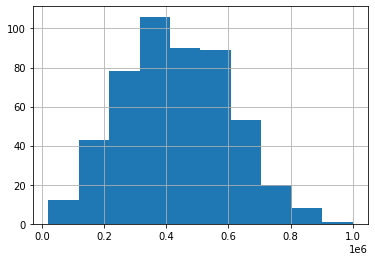

In [ ]:
df['Net Worth'].hist();

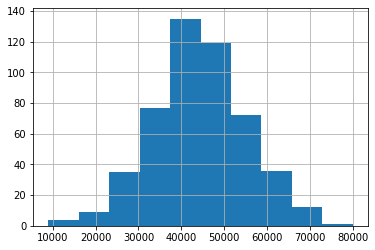

In [ ]:
df['Car Purchase Amount'].hist();

Modelos lineares se comportam melhor com distribuições que não sejam do tipo *cauda longa*. Como nos exemplos apresentados acima não temos um caso parecido, irei deixar desta maneira

Sabemos que todos os dados em um dataset são importantes e podem ser necessários para a criação e treinamento de um modelo. Porém, para fins didáticos e afim de facilitar o aprendizado estarei removendo as colunas *Customer Name*, *Customer e-mail* e	*Country* 

In [ ]:
df = df.drop(columns=['Customer Name', 'Customer e-mail', 'Country'])
df

,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
0,0,42,62812.09301,11609.380910,238961.2505,35321.45877
1,0,41,66646.89292,9572.957136,530973.9078,45115.52566
2,1,43,53798.55112,11160.355060,638467.1773,42925.70921
3,1,58,79370.03798,14426.164850,548599.0524,67422.36313
4,1,57,59729.15130,5358.712177,560304.0671,55915.46248
...,...,...,...,...,...,...
495,0,41,71942.40291,6995.902524,541670.1016,48901.44342
496,1,38,56039.49793,12301.456790,360419.0988,31491.41457
497,1,54,68888.77805,10611.606860,764531.3203,64147.28888
498,1,59,49811.99062,14013.034510,337826.6382,45442.15353


In [ ]:
df.rename(columns={'Gender': 'gender',
                   'Age': 'age',
                   'Annual Salary': 'annual_salary',
                   'Credit Card Debt': 'credit_card_debt',
                   'Net Worth': 'net_worth',
                   'Car Purchase Amount': 'car_purchase_amount'},
          inplace=True)

In [ ]:
df.columns

Index(['gender', 'age', 'annual_salary', 'credit_card_debt', 'net_worth',
       'car_purchase_amount'],
      dtype='object')

## 4.3 Configurando modelo

Agora podemos criar nossas variáveis ​​independentes (preditores) e dependentes (alvo). A variável dependente será *Car Purchase Amount* e as variáveis ​​independentes são todas as variáveis restantes.

In [ ]:
t_dep = df.iloc[:,:-1] #usado para selecionar linhas e colunas por número, na ordem em que aparecem no quadro de dados
t_dep #X

,gender,age,annual_salary,credit_card_debt,net_worth
0,0,42,62812.09301,11609.380910,238961.2505
1,0,41,66646.89292,9572.957136,530973.9078
2,1,43,53798.55112,11160.355060,638467.1773
3,1,58,79370.03798,14426.164850,548599.0524
4,1,57,59729.15130,5358.712177,560304.0671
...,...,...,...,...,...
495,0,41,71942.40291,6995.902524,541670.1016
496,1,38,56039.49793,12301.456790,360419.0988
497,1,54,68888.77805,10611.606860,764531.3203
498,1,59,49811.99062,14013.034510,337826.6382


In [ ]:
t_indep = df.iloc[:,-1]
t_indep #Y

0      35321.45877
1      45115.52566
2      42925.70921
3      67422.36313
4      55915.46248
          ...     
495    48901.44342
496    31491.41457
497    64147.28888
498    45442.15353
499    45107.22566
Name: car_purchase_amount, Length: 500, dtype: float64

Antes de começarmos a treinar nosso modelo, precisamos garantir que tenhamos um conjunto de validação para calcular nossas métricas. Há muitas maneiras diferentes de fazer isso. Como queremos garantir que a divisão dos dados seja da mesma maneira, vamos usar o *train_test_split* para obter índices que dividirão nossos dados em conjuntos de treinamento e teste

In [ ]:
dep_train, dep_test, indep_train, indep_test = train_test_split(t_dep, t_indep, test_size=0.2,random_state=0)

A seguir está o conteúdo de cada variável

In [ ]:
dep_train

,gender,age,annual_salary,credit_card_debt,net_worth
107,1,50,42433.54619,7335.524826,386057.4210
336,0,51,71921.45038,6354.372629,169714.2655
71,0,56,57393.82872,5627.803654,411831.0371
474,0,32,73558.87334,11164.526520,301245.7708
6,1,47,39814.52200,5958.460188,326373.1812
...,...,...,...,...,...
323,0,34,49607.23466,9344.323770,290711.8670
192,0,39,69248.49530,6445.784981,298246.0609
117,0,35,84171.16719,12719.644150,244310.5736
47,0,51,57478.37922,2230.096344,158979.7102


In [ ]:
dep_test

,gender,age,annual_salary,credit_card_debt,net_worth
90,1,50,60536.20406,8244.470226,173079.1798
254,0,45,68499.69447,15436.799680,308445.8598
283,1,41,59060.08664,5841.612044,136346.3069
445,0,53,76318.87883,6392.211408,245216.1691
461,1,39,58632.58875,12035.370790,516817.3173
...,...,...,...,...,...
372,1,35,72948.11812,12664.320520,360457.0496
56,1,34,84467.78988,7772.444847,468238.7915
440,1,40,57777.15558,19692.912620,601210.2803
60,1,42,46689.41590,7829.565502,615765.9289


In [ ]:
indep_train

107    34642.60240
336    45857.75365
71     49373.37555
474    35139.24793
6      28925.70549
          ...     
323    22630.25982
192    37879.65385
117    41451.71843
47     37843.46619
172    43724.48960
Name: car_purchase_amount, Length: 400, dtype: float64

In [ ]:
indep_test

90     38955.21919
254    43401.56612
283    29417.64694
445    52150.41786
461    38243.06228
          ...     
372    38545.80328
56     47380.91224
440    41147.46679
60     37348.13737
208    32478.44758
Name: car_purchase_amount, Length: 100, dtype: float64

# 4.4 Modelando usando Regressão Linear


Para a modelagem de dados será suado o Scikit-learn que é uma biblioteca do Python que simplifica a implementação de uma ampla variedade de métodos de aprendizado de máquina (ML) para análise preditiva de dados, incluindo regressão linear. A *regressão linear* pode ser considerada como encontrar a linha reta que melhor se ajusta a um conjunto de pontos de dados dispersos. É possível, então, projetar essa linha para prever novos pontos de dados

Para ajustar nosso modelo, primeiramente iremos chamar o método *LinearRegression()* que, do ponto de vista da implementação, cria uma instância de um modelo de regressão linear usando *mínimos quadrados comuns*. Após isso, iremos ajusta-los usando o método *fit()* passando nossos valores de X e Y representadas pelas variáveis dep_train e indep_train

In [ ]:
regressor = LinearRegression()
regressor.fit(dep_train.values,indep_train.values)

LinearRegression()

Agora passamos as variáveis dependetes para realizar algumas previsões

In [ ]:
indep_pred = regressor.predict(dep_test.values)

Podemos comparar nossas previsões com os valores já informados

In [ ]:
np.stack((indep_test,indep_pred),axis=1)

array([[38955.21919   , 39003.00084416],
       [43401.56612   , 43203.89808005],
       [29417.64694   , 29543.73079522],
       [52150.41786   , 52439.01382905],
       [38243.06228   , 38677.30366517],
       [53017.26723   , 52788.60271269],
       [60526.97788   , 60922.42671759],
       [59538.40327   , 59596.34616066],
       [37714.31659   , 37706.39436146],
       [31300.54347   , 31508.55427646],
       [46846.7305    , 46830.30013497],
       [56973.18105   , 57135.34380542],
       [53993.44322   , 53666.17127933],
       [70878.29664   , 70660.09997882],
       [27889.95197   , 27552.38221244],
       [31526.04931   , 31366.85969141],
       [47979.48549   , 47712.72517455],
       [58667.06865   , 58967.67520742],
       [42369.64247   , 42381.91125901],
       [10092.22509   , 10183.81037496],
       [48518.90163   , 48125.85236797],
       [37183.10293   , 37097.01030293],
       [46325.50959   , 46574.04028913],
       [27586.71854   , 27362.43289274],
       [68925.09

## 4.5 Calculando a acurácia


Para o calculo da acurácia iremos usar a [*pontução r2*](https://www.bmc.com/blogs/mean-squared-error-r2-and-variance-in-regression-analysis/). Trata-se de um método para verificar a correlação, ou seja, a variação entre duas variáveis

In [ ]:
indep_pred[1],indep_test[1]

(43203.898080046645, 45115.52566)

In [ ]:
df = pd.DataFrame({'Original Value':indep_test, 'Predicted Value':indep_pred})
df.head()

,Original Value,Predicted Value
90,38955.21919,39003.000844
254,43401.56612,43203.898080
283,29417.64694,29543.730795
445,52150.41786,52439.013829
461,38243.06228,38677.303665


In [ ]:
r2 = r2_score(indep_pred,indep_test)
r2

0.9994877269250894

A melhor pontuação possível é 1,0 e pode ser negativa (porque o modelo pode ser arbitrariamente pior). Podemos observar, então, que a acurácia para o modelo é ótima

# Analisando erro absoluto


Para verificar o erro médio absoluto (MAE) será utilizado o método *mean_absolute_error()* parassando dois parâmetros: Y real e o Y que prevemos. O MAE é calculado como a soma dos erros absolutos dividido pelo tamanho da amostra, sendo que o erro absoluto é a diferença entre o valor medido e o valor real

In [ ]:
print('Mean Absolute Error : ',metrics.mean_absolute_error(indep_test,indep_pred))

Mean Absolute Error :  216.36020860000056


Acima está a média ponderada de todos os erros. Como temos 100 valores de amostra, podemos calcular o erro absoluto de cada entrada como aproximadamente

In [ ]:
216.36/100

# 5. Deploy

A aplicação pode ser acessada por meio do link abaixo

Link HuggingFace: [Car Purchase Amount Analysis](https://huggingface.co/spaces/jackesfonseca/car-purchasing)

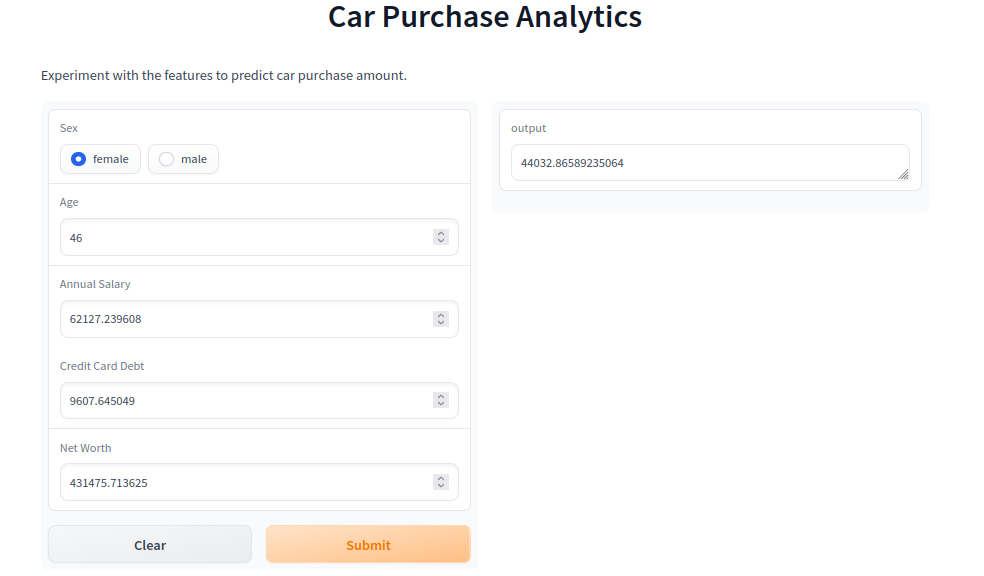